# Assignment 2 - Calibration and DLT
**Author:** Johannes Holmgren

In [17]:
# Import external modules
# Uncomment below to have interactive 3D models
# %matplotlib widget
import math
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.io import loadmat
from scipy.linalg import null_space, inv, qr
import cv2
from skimage import transform

# Import internal modules/files
import plotter
import utils

In [18]:
# ----- Constants -----
MAT_PATH = 'data/mat/'      # Path to data
IMG_PATH = 'data/images/'   # Path to images
# ---------------------

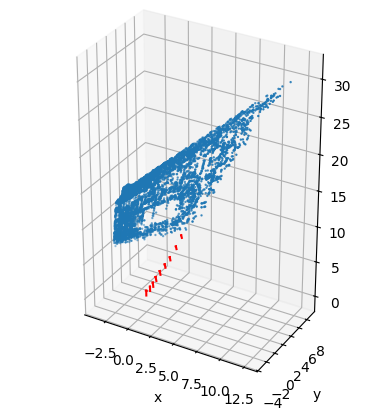

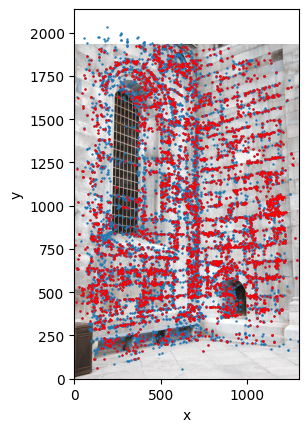

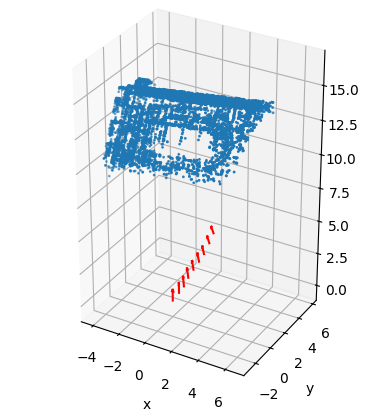

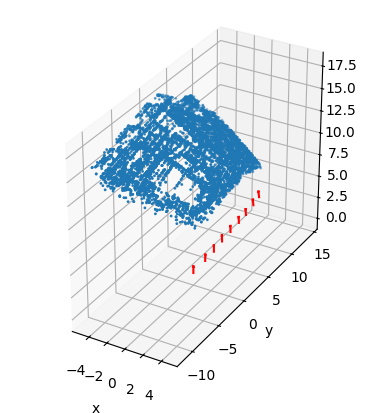

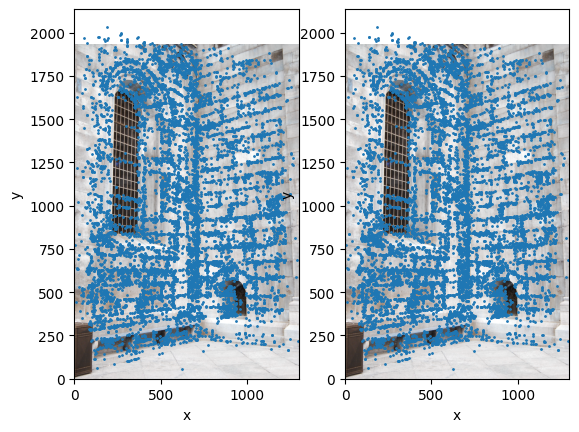

In [19]:
# Computer Exercise 1

# ----- Load data -----
compEx1data = loadmat(MAT_PATH + 'compEx1data.mat')
x       = compEx1data['x'][0]
P       = compEx1data['P'][0]
X       = compEx1data['X']
imfiles = compEx1data['imfiles']
# ---------------------

# ----- Define figure -----
fig = plt.figure()
ax_3D = fig.add_subplot(111, projection='3d')
ax_3D.set_aspect('equal')

# Plot 3D points
plotter.plot_points_3D(ax_3D, X, s=0.5)

# Plot cameras
cameras = [utils.camera_center_and_axis(camera) for camera in P]
centers, axes = map(np.array, zip(*cameras))
plotter.plot_cams(ax_3D, centers, axes, 1)

plt.show()

### Answer to question: Yes the phyiscal properties look realistic

# Project into Camera 1
CAMERA_INDEX = 0
fig_2D, ax_2D = plt.subplots()
ax_2D.set_aspect('equal')

# Display image
image = cv2.imread(IMG_PATH + imfiles[CAMERA_INDEX][0][0])
ax_2D.imshow(cv2.flip(image, 0))
ax_2D.invert_yaxis()

X_norm = utils.pflat(X)
X_proj = np.matmul(P[CAMERA_INDEX], X_norm)
X_proj_norm = utils.pflat(X_proj)

plotter.plot_points_2D(ax_2D, X_proj_norm, s=0.5, rev=True)
plotter.plot_points_2D(ax_2D, x[CAMERA_INDEX], c='r', s=0.5, rev=True)

plt.show()

### Answer to the questions: Yes the points are very close to each other

T1 = np.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, 0],
    [1/16, 1/16, 0, 1]
])
T2 = np.array([
    [1, 0, 0, 0],
    [0, 3, 0, 0],
    [0, 0, 1, 0],
    [1/9, 1/9, 0, 1]
])

# Transform 3D coordinates using T1 and T2
X_T1 = np.matmul(T1, X_norm)
X_T1_norm = utils.pflat(X_T1)
X_T2 = np.matmul(T2, X_norm)
X_T2_norm = utils.pflat(X_T2)

# Transform cameras by multiplying P*H_inv
P_T1 = np.array([np.matmul(p, inv(T1)) for p in P])
P_T2 = np.array([np.matmul(p, inv(T2)) for p in P])
P_T1_norm = utils.pflat(P_T1)
P_T2_norm = utils.pflat(P_T2)

# Plot T1 Cameras and Points
fig_3D = plt.figure()
ax_3D = fig_3D.add_subplot(projection='3d')
ax_3D.set_aspect('equal')

cameras = [utils.camera_center_and_axis(camera) for camera in P_T1]
centers, axes = map(np.array, zip(*cameras))

plotter.plot_cams(ax_3D, centers, axes, 1)
plotter.plot_points_3D(ax_3D, X_T1_norm)
plt.show()

# Plot T2 Cameras and Points
fig_3D = plt.figure()
ax_3D = fig_3D.add_subplot(projection='3d')
ax_3D.set_aspect('equal')

cameras = [utils.camera_center_and_axis(camera) for camera in P_T2]
centers, axes = map(np.array, zip(*cameras))

plotter.plot_cams(ax_3D, centers, axes, 1)
plotter.plot_points_3D(ax_3D, X_T2_norm)
plt.show()

### Answer to question: Yes, the first transform (T1) looks very reasonable

# Project new 3D points for T1 and T2 onto the transformed camera P1
def project_and_plot(ax, P, Xs, image):
    ''' Project Xs onto P and plot in same figure as image
    
    TBD
    '''
    X_norm = utils.pflat(Xs)
    X_proj = np.matmul(P, X_norm)
    X_proj_norm = utils.pflat(X_proj)
    ax.imshow(cv2.flip(image, 0))
    ax.invert_yaxis()
    plotter.plot_points_2D(ax, X_proj_norm, rev=True)


fig_2D, axs_2D = plt.subplots(1, 2)
axs_2D[0].set_aspect('equal')
axs_2D[1].set_aspect('equal')

# Project points onto each transformed camera
P_T1_1 = P_T1[CAMERA_INDEX]
P_T2_1 = P_T2[CAMERA_INDEX]

project_and_plot(axs_2D[0], P_T1_1, X_T1_norm, image)
project_and_plot(axs_2D[1], P_T2_1, X_T2_norm, image)

### Answer to question: T1 seems to do a proper projection onto the image, while the other gives a compacted version


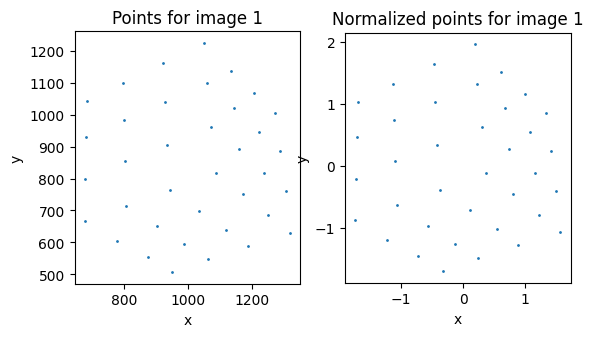

Smallest singular value is 0.051034141134844564
||Mv|| is 0.051034141134844585


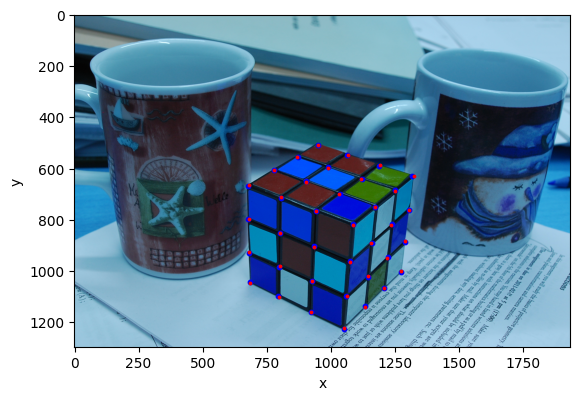

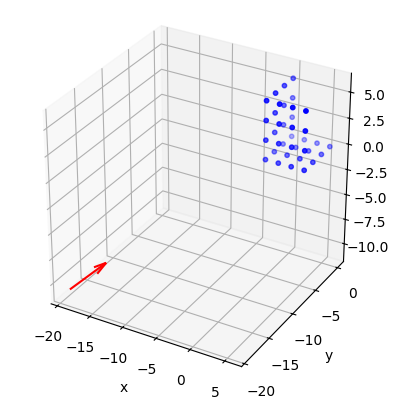

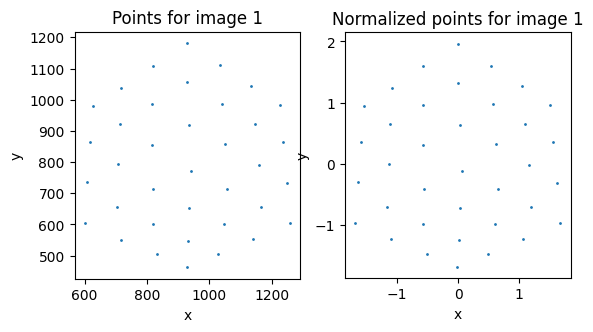

Smallest singular value is 0.043782183046001816
||Mv|| is 0.04378218304600191


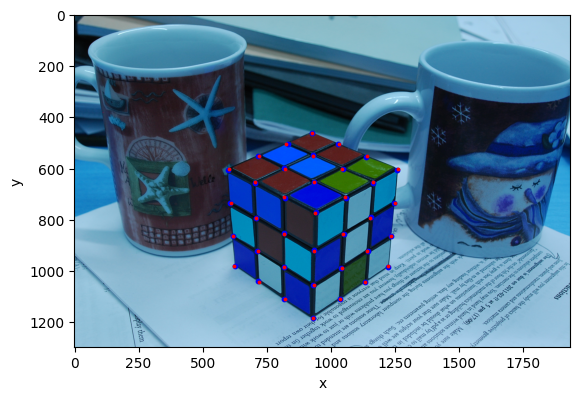

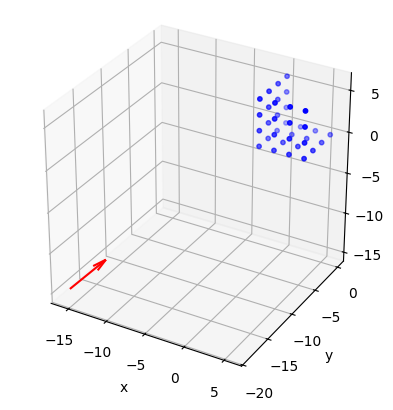

In [ ]:
# Computer Exercise 2

# ----- Load data -----
compEx2data = loadmat(MAT_PATH + 'compEx2data.mat')
x2       = compEx2data['x'][0]
Xmodel   = compEx2data['Xmodel']
startind = compEx2data['startind']
endind   = compEx2data['endind']

cube1 = cv2.imread(IMG_PATH + 'cube1.jpg')
cube2 = cv2.imread(IMG_PATH + 'cube2.jpg')

x2_1 = x2[0]
x2_2 = x2[1]
# ---------------------

# fig, ax = plt.subplots()

# ----- Camera 1 -----
# Normalize measured points
meanX = np.mean(x2_1[0])
meanY = np.mean(x2_1[1])
stdX = np.std(x2_1[0])
stdY = np.std(x2_1[1])

N = np.array([
    [1 / stdX, 0,        -meanX / stdX],
    [0,        1 / stdY, -meanY / stdY],
    [0,        0,                    1]
])

x2_1N = np.matmul(N, x2_1)

# Plot normalized points
fig, axs_1 = plt.subplots(1, 2)
axs_1[0].set_aspect('equal')
axs_1[1].set_aspect('equal')
plotter.plot_points_2D(axs_1[0], x2_1)
plotter.plot_points_2D(axs_1[1], x2_1N)
axs_1[0].set_title('Points for image 1')
axs_1[1].set_title('Normalized points for image 1')
plt.show()

### Answer: The points are centered around 0 with standard deviation 1

def estimate_camera_DLT_old(xs: np.ndarray, Xs: np.ndarray) -> np.ndarray:
    ''' Solve Homogeneous least squares for DLT equations using SVD. '''
    pDim = Xs.shape[0]
    nRows = 3 * Xs.shape[1]         # Each point gives three rows in M
    nCols = pDim * 3 + Xs.shape[1]  # Fit 3 times X and all lambdas
    M = np.zeros((nRows, nCols))
    # Iterate each point
    for i, (x, X) in enumerate(zip(xs.T, Xs.T)):
        for j in range(3):
            row = 3*i + j
            M[row, j:j+pDim] = X
            M[row, i + pDim * 3] = -x[j]

    # Perform svd to find V    
    U, S, Vh = np.linalg.svd(M)
    # Get last column of V
    v = Vh[-1]
    # Smallest singular value is given by the last element in S
    sv_min = S[-1]
    return (M, v, sv_min)

def estimate_camera_DLT(xs: np.ndarray, Xs: np.ndarray) -> np.ndarray:
    ''' Solve Homogeneous least squares for DLT equations using SVD. '''
    nPoints = Xs.shape[1]
    M = np.zeros((2 * nPoints, 12))
    # Iterate each point
    for i, (x, X) in enumerate(zip(xs.T, Xs.T)):
        M[2 * i] = [-X[0], -X[1], -X[2], -X[3], 0, 0, 0, 0, x[0] * X[0], x[0] * X[1], x[0] * X[2], x[0] * X[3]]
        M[2 * i + 1] = [0, 0, 0, 0, -X[0], -X[1], -X[2], -X[3], x[1] * X[0], x[1] * X[1], x[1] * X[2], x[1] * X[3]]
    # Perform svd to find V    
    U, S, Vh = np.linalg.svd(M)
    # Get last column of V
    v = Vh[-1]
    # Smallest singular value is given by the last element in S
    sv_min = S[-1]
    return (M, v, sv_min)

# Convert Xmodel to homogenenous coordinates
Xmodel_hom = np.vstack([Xmodel, np.ones(Xmodel.shape[1]).reshape(1, -1)])
M, v, sv_min = estimate_camera_DLT(x2_1N, Xmodel_hom)

print("Smallest singular value is", sv_min)
print("||Mv|| is", np.linalg.norm(np.matmul(M, v)))

### Answers: The smallest singular value is close to zero. ||Mv|| is also very close to zero

# Get camera P and test direction
P_norm = v[:12].reshape(3, 4)

# Flip camera if projecting to negative z-values
if np.matmul(P_norm, Xmodel_hom[:,0])[2] < 0:
    P_norm *= -1

# Un-normalize camera
P = np.matmul(inv(N), P_norm)

# Project and plot model points onto the image
fig, ax = plt.subplots()
ax.set_aspect('equal')

# Plot image and original points
# ax.imshow(cv2.flip(cube1, 0))
# x2_1_flipped = utils.flip_points(x2_1, cube1.shape[0])
# plotter.plot_points_2D(ax, x2_1_flipped, c='r', s=2)
# ax.invert_yaxis()
ax.imshow(cube1)
plotter.plot_points_2D(ax, x2_1, c='b', s=10)

# Project and plot the 3D points
X_proj_1 = np.matmul(P, Xmodel_hom)
X_proj_1_norm = utils.pflat(X_proj_1)

plotter.plot_points_2D(ax, X_proj_1_norm, 'r', s=3)
plt.show()

# Make a 3D plot showing the camera and the 3D points
fig_3D = plt.figure()
ax_3D = fig_3D.add_subplot(projection='3d')
plotter.plot_points_3D(ax_3D, Xmodel_hom, c='b', s=10)
center, axis = utils.camera_center_and_axis(P)
plotter.plot_camera(ax_3D, center, axis, scale=5)

plt.show()

### Answers: Yes the plot looks reasonable. Note that the points in the 2D image are plotted upside down
###          and thus the 3D image is flipped in z-direction

# ----- Camera 2 -----
# Normalize measured points
meanX = np.mean(x2_2[0])
meanY = np.mean(x2_2[1])
stdX = np.std(x2_2[0])
stdY = np.std(x2_2[1])

N = np.array([
    [1 / stdX, 0,        -meanX / stdX],
    [0,        1 / stdY, -meanY / stdY],
    [0,        0,                    1]
])

x2_2N = np.matmul(N, x2_2)

# Plot normalized points
fig, axs_1 = plt.subplots(1, 2)
axs_1[0].set_aspect('equal')
axs_1[1].set_aspect('equal')
plotter.plot_points_2D(axs_1[0], x2_2)
plotter.plot_points_2D(axs_1[1], x2_2N)
axs_1[0].set_title('Points for image 1')
axs_1[1].set_title('Normalized points for image 1')
plt.show()

### Answer: The points are centered around 0 with standard deviation 1

def estimate_camera_DLT_old(xs: np.ndarray, Xs: np.ndarray) -> np.ndarray:
    ''' Solve Homogeneous least squares for DLT equations using SVD. '''
    pDim = Xs.shape[0]
    nRows = 3 * Xs.shape[1]         # Each point gives three rows in M
    nCols = pDim * 3 + Xs.shape[1]  # Fit 3 times X and all lambdas
    M = np.zeros((nRows, nCols))
    # Iterate each point
    for i, (x, X) in enumerate(zip(xs.T, Xs.T)):
        for j in range(3):
            row = 3*i + j
            M[row, j:j+pDim] = X
            M[row, i + pDim * 3] = -x[j]

    # Perform svd to find V    
    U, S, Vh = np.linalg.svd(M)
    # Get last column of V
    v = Vh[-1]
    # Smallest singular value is given by the last element in S
    sv_min = S[-1]
    return (M, v, sv_min)

def estimate_camera_DLT(xs: np.ndarray, Xs: np.ndarray) -> np.ndarray:
    ''' Solve Homogeneous least squares for DLT equations using SVD. '''
    nPoints = Xs.shape[1]
    M = np.zeros((2 * nPoints, 12))
    # Iterate each point
    for i, (x, X) in enumerate(zip(xs.T, Xs.T)):
        M[2 * i] = [-X[0], -X[1], -X[2], -X[3], 0, 0, 0, 0, x[0] * X[0], x[0] * X[1], x[0] * X[2], x[0] * X[3]]
        M[2 * i + 1] = [0, 0, 0, 0, -X[0], -X[1], -X[2], -X[3], x[1] * X[0], x[1] * X[1], x[1] * X[2], x[1] * X[3]]
    # Perform svd to find V    
    U, S, Vh = np.linalg.svd(M)
    # Get last column of V
    v = Vh[-1]
    # Smallest singular value is given by the last element in S
    sv_min = S[-1]
    return (M, v, sv_min)

# Convert Xmodel to homogenenous coordinates
Xmodel_hom = np.vstack([Xmodel, np.ones(Xmodel.shape[1]).reshape(1, -1)])
M, v, sv_min = estimate_camera_DLT(x2_2N, Xmodel_hom)

print("Smallest singular value is", sv_min)
print("||Mv|| is", np.linalg.norm(np.matmul(M, v)))

### Answers: The smallest singular value is close to zero. ||Mv|| is also close to zero

# Get camera P and test direction
P_norm = v[:12].reshape(3, 4)

# Flip camera if projecting to negative z-values
if np.matmul(P_norm, Xmodel_hom[:,0])[2] < 0:
    P_norm *= -1

# Un-normalize camera
P = np.matmul(inv(N), P_norm)

# Project and plot model points onto the image
fig, ax = plt.subplots()
ax.set_aspect('equal')


ax.imshow(cube2)
plotter.plot_points_2D(ax, x2_2, c='b', s=10)

# Project and plot the 3D points
X_proj_1 = np.matmul(P, Xmodel_hom)
X_proj_1_norm = utils.pflat(X_proj_1)

plotter.plot_points_2D(ax, X_proj_1_norm, 'r', s=3)
plt.show()

# Make a 3D plot showing the camera and the 3D points
fig_3D = plt.figure()
ax_3D = fig_3D.add_subplot(projection='3d')
plotter.plot_points_3D(ax_3D, Xmodel_hom, c='b', s=10)
center, axis = utils.camera_center_and_axis(P)
plotter.plot_camera(ax_3D, center, axis, scale=5)

plt.show()

----- Camera 1 -----
Smallest singular value is 0.05103
||Mv|| =  0.051
----- Camera 2 -----
Smallest singular value is 0.04378
||Mv|| =  0.044


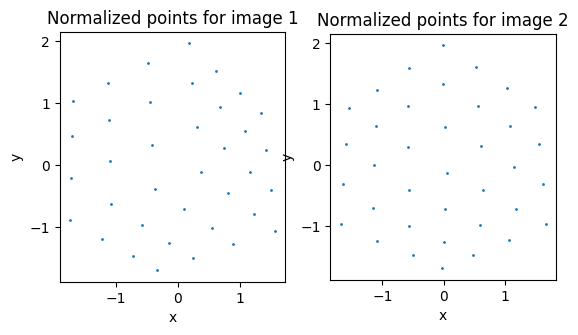

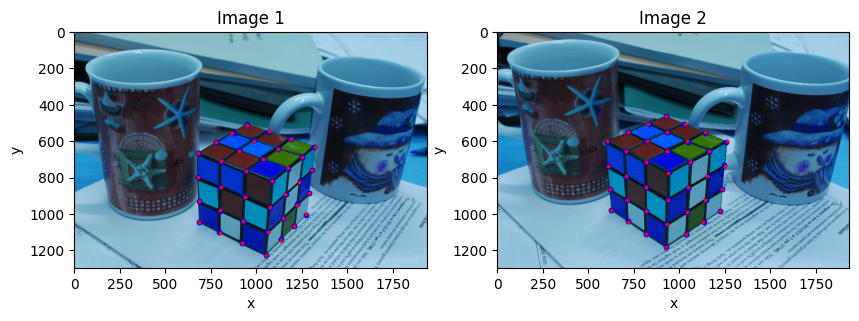

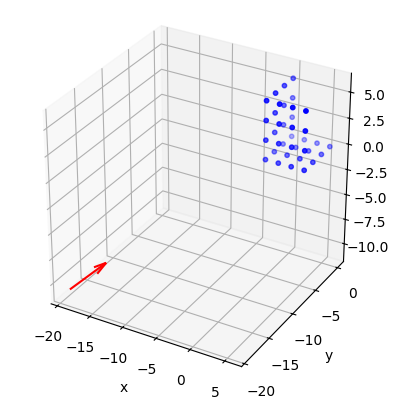

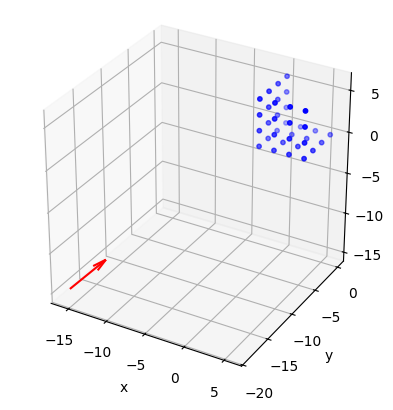

In [ ]:
# Computer Exercise 2

def get_normalization_matrix(xs: np.ndarray) -> np.ndarray:
    ''' Get the normalization matrix which subtracts mean and divides by std_dev. 

    Takes the mean and std_dev for x-values and y-values separately.

    Parameters
    ----------
    xs: np.ndarray
        The points to normalize
    
    Returns
    -------
    np.ndarray
        The normalization matrix

    '''
    meanX = np.mean(xs[0])
    meanY = np.mean(xs[1])
    stdX  = np.std(xs[0])
    stdY  = np.std(xs[1])
    N = np.array([
        [1 / stdX,        0, -meanX / stdX],
        [0,        1 / stdY, -meanY / stdY],
        [0,               0,             1]
    ])
    return N

def estimate_camera_DLT(xs: np.ndarray, Xs: np.ndarray) -> np.ndarray:
    ''' Solve Homogeneous least squares for DLT equations using SVD.

    Used to find the camera matrix P that projects Xs onto xs 
    
    Parameters
    ----------
    xs: np.ndarray
        The projected points onto P

    Xs: np.ndarray
        The 3D model points that was projected

    Returns
    -------
    np.ndarray
        The v-vector from the solution min(||Mv||),
        which contains the camera matrix P as its first 12 elements.
    '''
    # Create M
    nPoints = Xs.shape[1]
    M = np.zeros((2 * nPoints, 12))
    for i, (x, X) in enumerate(zip(xs.T, Xs.T)):
        M[2 * i] = [-X[0], -X[1], -X[2], -X[3], 0, 0, 0, 0, x[0] * X[0], x[0] * X[1], x[0] * X[2], x[0] * X[3]]
        M[2 * i + 1] = [0, 0, 0, 0, -X[0], -X[1], -X[2], -X[3], x[1] * X[0], x[1] * X[1], x[1] * X[2], x[1] * X[3]]
    # Find v as last row of Vh in SVD
    U, S, Vh = np.linalg.svd(M)
    v = Vh[-1]
    # Smallest singular value is given by the last element in S
    sv_min = S[-1]
    return (M, v, sv_min)

def rq(a):
    ''' Performs RQ-factorization on a
    
    Factorizes a matrix 'a' such that a = RQ,
    where R is upper triangular, and Q is a unitary matrix.
    If 'a' is not square, Q is partitioned as Q = [Q1 Q2], where Q1 is unitary.

    Parameters:
    -----------
    a numpy.ndarray: 
        Input matrix (m x n).
        
    Returns:
        r numpy.ndarray: 
            Upper triangular matrix (m x m).
        q numpy.ndarray: 
            Unitary matrix (m x n).

    '''
    m, n = a.shape
    e = np.eye(m)
    # Permutation matrix to reverse rows
    p = e[:, ::-1]
    
    # Perform QR decomposition on the permuted matrix
    q0, r0 = qr(np.dot(p, np.dot(a[:, :m].T, p)))
    
    # Adjust to compute R and Q for the original matrix
    r = np.dot(np.dot(p, r0.T), p)
    q = np.dot(np.dot(p, q0.T), p)
    
    # Fix the signs to ensure R has positive diagonal elements
    fix = np.diag(np.sign(np.diag(r)))
    r = np.dot(r, fix)
    q = np.dot(fix, q)
    
    # Handle the case where the matrix is not square
    if n > m:
        q = np.hstack((q, np.linalg.inv(r) @ a[:, m:n]))
    
    return r, q


# ----- Load data -----
compEx2data = loadmat(MAT_PATH + 'compEx2data.mat')
x2       = compEx2data['x'][0]
Xmodel   = compEx2data['Xmodel']
startind = compEx2data['startind']
endind   = compEx2data['endind']

cube1 = cv2.imread(IMG_PATH + 'cube1.jpg')
cube2 = cv2.imread(IMG_PATH + 'cube2.jpg')

x2_1 = x2[0]
x2_2 = x2[1]

# Convert Xmodel to homogenenous coordinates
Xmodel_hom = np.vstack([Xmodel, np.ones(Xmodel.shape[1]).reshape(1, -1)])
# ---------------------

# Normalize measured points
N1 = get_normalization_matrix(x2_1)
N2 = get_normalization_matrix(x2_2)
x2_1N = np.matmul(N1, x2_1)
x2_2N = np.matmul(N2, x2_2)

# Plot normalized points
fig, axs = plt.subplots(1, 2)
axs[0].set_aspect('equal')
axs[1].set_aspect('equal')
plotter.plot_points_2D(axs[0], x2_1N)
plotter.plot_points_2D(axs[1], x2_2N)
axs[0].set_title('Normalized points for image 1')
axs[1].set_title('Normalized points for image 2')

### Answer: The points are centered around 0 with standard deviation 1

# Find v to find min(||Mv||)
M1, v1, sv1_min = estimate_camera_DLT(x2_1N, Xmodel_hom)
M2, v2, sv2_min = estimate_camera_DLT(x2_2N, Xmodel_hom)

print("----- Camera 1 -----")
print("Smallest singular value is", round(sv1_min, 5))
print("||Mv|| = ", round(np.linalg.norm(np.matmul(M1, v1)), 3))

print("----- Camera 2 -----")
print("Smallest singular value is", round(sv2_min, 5))
print("||Mv|| = ", round(np.linalg.norm(np.matmul(M2, v2)), 3))

### Answers: The smallest singular value is close to zero. ||Mv|| is also very close to zero

# Get camera P and test direction
P1_norm = v1[:12].reshape(3, 4)
P2_norm = v2[:12].reshape(3, 4)

# Flip camera if projecting to negative z-values
if np.matmul(P1_norm, Xmodel_hom[:,0])[2] < 0:
    P1_norm *= -1
if np.matmul(P2_norm, Xmodel_hom[:,0])[2] < 0:
    P2_norm *= -1

# Un-normalize camera
P1 = np.matmul(inv(N1), P1_norm)
P2 = np.matmul(inv(N2), P2_norm)

# Plot images, given points and projected points onto the images
fig, axs = plt.subplots(1, 2)
fig.set_figheight(10)
fig.set_figwidth(10)
axs[0].set_aspect('equal')
axs[1].set_aspect('equal')

axs[0].imshow(cube1)
plotter.plot_points_2D(axs[0], x2_1, c='b', s=10)
axs[1].imshow(cube2)
plotter.plot_points_2D(axs[1], x2_2, c='b', s=10)

X_proj_1 = np.matmul(P1, Xmodel_hom)
X_proj_1_norm = utils.pflat(X_proj_1)
X_proj_2 = np.matmul(P2, Xmodel_hom)
X_proj_2_norm = utils.pflat(X_proj_2)

plotter.plot_points_2D(axs[0], X_proj_1_norm, 'r', s=3)
plotter.plot_points_2D(axs[1], X_proj_2_norm, 'r', s=3)

axs[0].set_title('Image 1')
axs[1].set_title('Image 2')

# Make a 3D plot showing the camera and the 3D points
fig_3D = plt.figure()
ax_3D = fig_3D.add_subplot(projection='3d')
ax_3D.set_aspect('equal')
plotter.plot_points_3D(ax_3D, Xmodel_hom, c='b', s=10)
center, axis = utils.camera_center_and_axis(P1)
plotter.plot_camera(ax_3D, center, axis, scale=5)

fig_3D = plt.figure()
ax_3D = fig_3D.add_subplot(projection='3d')
ax_3D.set_aspect('equal')
plotter.plot_points_3D(ax_3D, Xmodel_hom, c='b', s=10)
center, axis = utils.camera_center_and_axis(P2)
plotter.plot_camera(ax_3D, center, axis, scale=5)

### Answers: Yes the plot looks reasonable. Note that the points in the 2D image are plotted upside down
###          and thus the 3D image is flipped in z-direction

